In [ ]:
import pandas as pd
import numpy as np
from functools import reduce

df = pd.read_csv('datasets/san_diego_listings.csv')
df.head()

df.shape

df.columns

## drop columns that we are not using
columns_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'description', 'neighborhood_overview', 'picture_url', 
                   'host_url', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                   'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 
                   'neighbourhood', 'neighbourhood_group_cleansed', 'minimum_minimum_nights', 'maximum_minimum_nights', 
                   'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                   'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 
                   'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                   'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

df.columns

## For price column, convert to numeric only format
df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'])

numeric_columns = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
                   'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 
                   'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy',
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                   'review_scores_location', 'review_scores_value', 'reviews_per_month']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

rows_with_missing = df[df.isna().any(axis=1)]

# Display the rows with missing values
print(rows_with_missing)

## drop rows that has missing values
df_cleaned = df.dropna()
df_cleaned.shape

missing_data_summary = df_cleaned.isnull().sum()
print("Missing data summary:\n", missing_data_summary)

## sort data with id
df_sorted = df_cleaned.sort_values(by='id')
df_sorted.head()

df_sorted.to_csv('san_diego_listing_cleaned.csv', index=False)



In [ ]:
import pandas as pd 
import numpy as np
#make pandas display all columns
pd.set_option('display.max_columns', None)

san_diego = pd.read_csv('san_diego_listing_cleaned.csv')
san_diego.head()



numeric_df = san_diego.drop(columns=["id", "name", "host_name", "amenities", "host_since", "bathrooms_text"], axis=1)

numeric_df["host_response_rate"] = numeric_df["host_response_rate"].str.replace("%", "").astype(float)
numeric_df["host_acceptance_rate"] = numeric_df["host_acceptance_rate"].str.replace("%", "").astype(float)

dummy_cols = ["host_response_time", "host_is_superhost", "host_identity_verified", "neighbourhood_cleansed", "property_type", "room_type"]
numeric_df = pd.get_dummies(numeric_df, columns=dummy_cols)

#print categorical columns
print(numeric_df.select_dtypes(include=['object']).columns)
for col in numeric_df.select_dtypes(include=['object']).columns:
    print(numeric_df[col].value_counts())


#co
#Find correlation matrix
corr_matrix = numeric_df.corr()
print(corr_matrix.shape)

#Find the most correlated features with price
corr_price = corr_matrix["price"].sort_values(ascending=False)
print("10 most positively correlated features with price")
print(corr_price[:10])
print("10 most negatively correlated features with price")
print(corr_price[-10:])

import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 10 most positively and negatively correlated features with price
positive_corr = corr_price[:10]
negative_corr = corr_price[-10:]

# Combine both into a single dataframe for visualization
combined_corr = pd.concat([positive_corr, negative_corr])

# Increase figure DPI for better resolution
plt.figure(figsize=(12, 8), dpi=150)

# Create the horizontal bar chart with improved styling
sns.barplot(
    x=combined_corr.values,
    y=combined_corr.index,
    palette=["#2E8B57" if val > 0 else "#FF6347" for val in combined_corr.values]
)

# Add title and labels with larger font sizes
plt.title('Top 10 Positive and Negative Correlations with Price', fontsize=18, weight='bold')
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Enhance grid readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


corr_rating = corr_matrix["review_scores_rating"].sort_values(ascending=False)
print("10 most positively correlated features with review_scores_rating")
print(corr_rating[:10])
print("10 most negatively correlated features with review_scores_rating")
print(corr_rating[-10:])


#drop review_scores_* and host_is_superhost_* columns
corr_rating = corr_rating.drop(index=corr_rating.index[corr_rating.index.str.contains("review_scores")])
corr_rating = corr_rating.drop(index=corr_rating.index[corr_rating.index.str.contains("host_is_superhost")])
print("10 most positively correlated features with review_scores_rating without review_scores_* and host_is_superhost_* columns")
print(corr_rating[:10])
print("10 most negatively correlated features with review_scores_rating without review_scores_* and host_is_superhost_* columns")
print(corr_rating[-10:])

import matplotlib.pyplot as plt

# Group by neighborhood and calculate the average price
avg_price_by_neighborhood = san_diego.groupby("neighbourhood_cleansed")["price"].mean().sort_values()

# Get the cheapest 5 neighborhoods
cheapest_neighborhoods = avg_price_by_neighborhood.head(5)

# Get the top 5 priciest neighborhoods
priciest_neighborhoods = avg_price_by_neighborhood.tail(5)

# Combine the two groups
combined_neighborhoods = pd.concat([cheapest_neighborhoods, priciest_neighborhoods])

# Increase DPI for higher resolution
plt.figure(figsize=(12, 8), dpi=150)

# Plot the data with enhanced styling
combined_neighborhoods.plot(
    kind='bar', 
    color=['green'] * 5 + ['red'] * 5, 
    edgecolor='black',
    alpha=0.85  # Slight transparency for visual appeal
)

# Add title and axis labels with larger fonts
plt.title('Top 5 Priciest and Cheapest Neighborhoods in San Diego', fontsize=16, weight='bold')
plt.ylabel('Average Price ($)', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)

# Improve x-tick readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add a grid for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure layout fits well
plt.tight_layout()

# Show the plot
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

# Group data by neighborhoods and calculate average price and longitude
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed')[['price', 'longitude']].mean().reset_index()

# Sort neighborhoods by average price
sorted_neighborhoods = neighborhood_stats.sort_values(by='price', ascending=False)

# Select top 10 and bottom 10 neighborhoods
top_10_neighborhoods = sorted_neighborhoods.head(10)
bottom_10_neighborhoods = sorted_neighborhoods.tail(10)

# Combine top and bottom neighborhoods for plotting
selected_neighborhoods = pd.concat([top_10_neighborhoods, bottom_10_neighborhoods])

# Set a higher resolution for better image quality
plt.figure(figsize=(14, 5.10), dpi=150)

# Plot a scatterplot of longitude vs. price with enhanced design
sns.scatterplot(
    data=selected_neighborhoods,
    x='longitude',
    y='price',
    hue='neighbourhood_cleansed',
    palette='viridis',
    s=150,  # Increase marker size
    edgecolor='black',  # Add edge color for better contrast
    linewidth=0.7
)

# Add labels and title with larger fonts
plt.title('Longitude vs Average Price for Top 10 and Bottom 10 Neighborhoods', fontsize=18, weight='bold')
plt.xlabel('Longitude (Negative = Closer to Coast)', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)

# Customize the legend for better readability
plt.legend(
    title='Neighborhood', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    fontsize=10, 
    title_fontsize=12, 
    frameon=True
)

# Add grid for better reference
plt.grid(linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by neighborhood and calculate average price and longitude
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average price
neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_price'], 5, labels=["Tier 1 (Lowest)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Highest)"])

# Calculate average longitude and average price for each tier
tier_stats = neighborhood_stats.groupby('tier').agg(
    avg_price=('avg_price', 'mean'),
    avg_longitude=('avg_longitude', 'mean')
).reset_index()

# Display neighborhoods in each tier
tier_neighborhoods = neighborhood_stats.groupby('tier')['neighbourhood_cleansed'].apply(list)
print("Neighborhoods in Each Tier:")
print(tier_neighborhoods)

# Plot the scatterplot
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(data=tier_stats, x='avg_longitude', y='avg_price', hue='tier', palette='coolwarm', s=150)

# Overlay a line connecting the tiers
sns.lineplot(data=tier_stats, x='avg_longitude', y='avg_price', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

# Add labels and title
plt.title('Average Price vs. Average Longitude Across Tiers', fontsize=16)
plt.xlabel('Average Longitude (by Tier)', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.legend(title='Price Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by neighborhood and calculate average price, bathrooms, bedrooms, accommodates, and beds
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_bathrooms=('bathrooms', 'mean'),
    avg_bedrooms=('bedrooms', 'mean'),
    avg_accommodates=('accommodates', 'mean'),
    avg_beds=('beds', 'mean')  # Added beds
).reset_index()

# Divide neighborhoods into 5 tiers based on average price
neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_price'], 5, labels=["Tier 1 (Lowest)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Highest)"])

# Define a function to create the desired plots with enhancements
def plot_relationship_with_tiers(df, feature, feature_label):
    # Calculate average feature and average price for each tier
    tier_stats = df.groupby('tier').agg(
        avg_price=('avg_price', 'mean'),
        avg_feature=(feature, 'mean')
    ).reset_index()

    # Increase resolution
    plt.figure(figsize=(12, 6), dpi=150)

    # Plot scatterplot
    sns.scatterplot(
        data=tier_stats,
        x='avg_feature',
        y='avg_price',
        hue='tier',
        palette='coolwarm',
        s=200,
        edgecolor='black',  # Marker edges for better contrast
        linewidth=1
    )

    # Overlay a line connecting the tiers
    sns.lineplot(
        data=tier_stats,
        x='avg_feature',
        y='avg_price',
        color='gray',
        marker='o',
        linestyle='-',
        linewidth=2,
        label='Trend Line',
        alpha=0.8
    )

    # Add labels and title
    plt.title(f'Average Price vs. Average {feature_label} Across Tiers', fontsize=18, weight='bold')
    plt.xlabel(f'Average {feature_label} (by Tier)', fontsize=14)
    plt.ylabel('Average Price ($)', fontsize=14)

    # Customize legend
    plt.legend(
        title='Price Tiers',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=10,
        title_fontsize=12,
        frameon=True
    )

    # Add grid for clarity
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create plots for bathrooms, bedrooms, accommodates, and beds
plot_relationship_with_tiers(neighborhood_stats, 'avg_bathrooms', 'Bathrooms')
plot_relationship_with_tiers(neighborhood_stats, 'avg_bedrooms', 'Bedrooms')
plot_relationship_with_tiers(neighborhood_stats, 'avg_accommodates', 'Accommodates')
plot_relationship_with_tiers(neighborhood_stats, 'avg_beds', 'Beds')  # Added beds plot


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by neighborhood and calculate average longitude, bathrooms, bedrooms, accommodates, and beds
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_longitude=('longitude', 'mean'),
    avg_bathrooms=('bathrooms', 'mean'),
    avg_bedrooms=('bedrooms', 'mean'),
    avg_accommodates=('accommodates', 'mean'),
    avg_beds=('beds', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average longitude
neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_longitude'], 5, labels=["Tier 1 (Closest to Coast)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Farthest from Coast)"])

# Define a function to plot the relationship for each feature
def plot_relationship_with_longitude_tiers(df, feature, feature_label):
    # Calculate average feature and longitude for each tier
    tier_stats = df.groupby('tier').agg(
        avg_longitude=('avg_longitude', 'mean'),
        avg_feature=(feature, 'mean')
    ).reset_index()

    # Plot the scatterplot
    plt.figure(figsize=(12, 6), dpi=150)
    sns.scatterplot(data=tier_stats, x='avg_longitude', y='avg_feature', hue='tier', palette='coolwarm', s=150)

    # Overlay a line connecting the tiers
    sns.lineplot(data=tier_stats, x='avg_longitude', y='avg_feature', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

    # Add labels and title
    plt.title(f'Average {feature_label} vs. Longitude Tiers', fontsize=16)
    plt.xlabel('Average Longitude (by Tier)', fontsize=14)
    plt.ylabel(f'Average {feature_label}', fontsize=14)
    plt.legend(title='Longitude Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create plots for bathrooms, bedrooms, accommodates, and beds
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_bathrooms', 'Bathrooms')
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_bedrooms', 'Bedrooms')
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_accommodates', 'Accommodates')
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_beds', 'Beds')




# Calculate average price for each longitude-based tier
tier_price_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average longitude (closer to the coast to farther)
tier_price_stats['tier'] = pd.qcut(tier_price_stats['avg_longitude'], 5, labels=["Tier 1 (Closest to Coast)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Farthest from Coast)"])

# Calculate the average price for each tier
tier_avg_price = tier_price_stats.groupby('tier').agg(
    avg_price=('avg_price', 'mean')
).reset_index()

# Display the average prices for each tier
print("Average Prices for Each Longitude-Based Tier:")
print(tier_avg_price)

# Plot average prices vs. longitude tiers
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(data=tier_avg_price, x='tier', y='avg_price', palette='coolwarm', s=150)

# Overlay a line connecting the tiers
sns.lineplot(data=tier_avg_price, x='tier', y='avg_price', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

# Add labels and title
plt.title('Average Price vs. Longitude Tiers', fontsize=16)
plt.xlabel('Longitude Tiers (from Closest to Farthest from Coast)', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.legend(title='Longitude Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

import pandas as pd

# Load the dataset
filtered_data = pd.read_csv('san_diego_listing_cleaned.csv')

# Ensure 'price' and 'availability_30' are numeric
filtered_data = filtered_data[filtered_data['availability_30'] != 30]
filtered_data = filtered_data[filtered_data['room_type'] == 'Entire home/apt']
filtered_data['price'] = pd.to_numeric(filtered_data['price'], errors='coerce')
filtered_data['availability_30'] = pd.to_numeric(filtered_data['availability_30'], errors='coerce')

# Calculate average yearly income generated
filtered_data['avg_yearly_income'] = (30 - filtered_data['availability_30']) * 12 * filtered_data['price']

# Calculate years to reach $1M
filtered_data['years_to_reach_1M'] = 1000000 / filtered_data['avg_yearly_income']

# Save the results to a new CSV file
filtered_data.to_csv('filtered_entire_home_data_with_income_and_years_1.csv', index=False)

print("Updated dataset saved to 'filtered_entire_home_data_with_income_and_years.csv'")


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated dataset with income and years_to_reach_1M columns
filtered_data = pd.read_csv('filtered_entire_home_data_with_income_and_years_1.csv')

# Ensure price and years_to_reach_1M are numeric
filtered_data['price'] = filtered_data['price'].astype(float)
filtered_data['years_to_reach_1M'] = pd.to_numeric(filtered_data['years_to_reach_1M'], errors='coerce')

# Group by neighborhood and calculate average price and years_to_reach_1M
neighborhood_stats = filtered_data.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_years_to_reach_1M=('years_to_reach_1M', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average price
neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_price'], 5, labels=["Tier 1 (Lowest)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Highest)"])

# Calculate average years_to_reach_1M for each tier
tier_stats = neighborhood_stats.groupby('tier').agg(
    avg_price=('avg_price', 'mean'),
    avg_years_to_reach_1M=('avg_years_to_reach_1M', 'mean')
).reset_index()

# Display neighborhoods in each tier
tier_neighborhoods = neighborhood_stats.groupby('tier')['neighbourhood_cleansed'].apply(list)
print("Neighborhoods in Each Tier:")
print(tier_neighborhoods)

# Plot the scatterplot
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(data=tier_stats, x='avg_price', y='avg_years_to_reach_1M', hue='tier', palette='coolwarm', s=150)

# Overlay a line connecting the tiers
sns.lineplot(data=tier_stats, x='avg_price', y='avg_years_to_reach_1M', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

# Add labels and title
plt.title('Average Years to Reach $1M vs. Average Price Across Tiers', fontsize=16)
plt.xlabel('Average Price (by Tier)', fontsize=14)
plt.ylabel('Average Years to Reach $1M Revenue', fontsize=14)
plt.legend(title='Price Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()





import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated dataset with income and years_to_reach_1M columns
filtered_data = pd.read_csv('filtered_entire_home_data_with_income_and_years_1.csv')

# Ensure longitude and years_to_reach_1M are numeric
filtered_data['longitude'] = pd.to_numeric(filtered_data['longitude'], errors='coerce')
filtered_data['years_to_reach_1M'] = pd.to_numeric(filtered_data['years_to_reach_1M'], errors='coerce')

# Group by neighborhood and calculate average longitude and years_to_reach_1M
neighborhood_stats = filtered_data.groupby('neighbourhood_cleansed').agg(
    avg_longitude=('longitude', 'mean'),
    avg_years_to_reach_1M=('years_to_reach_1M', 'mean')
).reset_index()

# Check for any NaN values in the calculated fields
neighborhood_stats = neighborhood_stats.dropna(subset=['avg_longitude', 'avg_years_to_reach_1M'])

# Divide neighborhoods into 5 tiers based on average longitude
# Ensure that the data is sufficient for 5 quantiles
if len(neighborhood_stats['avg_longitude'].dropna()) >= 5:
    neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_longitude'], 5, labels=["Tier 1 (Closest to coast)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Farthest from coast)"])
else:
    print("Not enough data to divide into 5 quantiles.")

# Calculate average years_to_reach_1M for each tier
tier_stats = neighborhood_stats.groupby('tier').agg(
    avg_longitude=('avg_longitude', 'mean'),
    avg_years_to_reach_1M=('avg_years_to_reach_1M', 'mean')
).reset_index()

# Display neighborhoods in each tier
tier_neighborhoods = neighborhood_stats.groupby('tier')['neighbourhood_cleansed'].apply(list)
print("Neighborhoods in Each Tier:")
print(tier_neighborhoods)

# Plot the scatterplot
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(data=tier_stats, x='avg_longitude', y='avg_years_to_reach_1M', hue='tier', palette='coolwarm', s=150)

# Overlay a line connecting the tiers
sns.lineplot(data=tier_stats, x='avg_longitude', y='avg_years_to_reach_1M', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

# Add labels and title
plt.title('Average Years to Reach $1M vs. Average Longitude Across Tiers', fontsize=16)
plt.xlabel('Average Longitude (by Tier)', fontsize=14)
plt.ylabel('Average Years to Reach $1M Revenue', fontsize=14)
plt.legend(title='Longitude Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()





import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
filtered_data = pd.read_csv('san_diego_listing_cleaned.csv')

# Ensure necessary columns are numeric
filtered_data['price'] = pd.to_numeric(filtered_data['price'], errors='coerce')
filtered_data['longitude'] = pd.to_numeric(filtered_data['longitude'], errors='coerce')
filtered_data['availability_30'] = pd.to_numeric(filtered_data['availability_30'], errors='coerce')

# Calculate average yearly occupancy
filtered_data['avg_yearly_occupancy'] = ((30 - filtered_data['availability_30']) * 1200) / 360

# Group neighborhoods by average price
price_tier_stats = filtered_data.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_yearly_occupancy=('avg_yearly_occupancy', 'mean')
).reset_index()

# Divide neighborhoods into price-based tiers
price_tier_stats['price_tier'] = pd.qcut(
    price_tier_stats['avg_price'], 5, labels=["Tier 1 (Lowest)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Highest)"]
)

# Group neighborhoods by average longitude
longitude_tier_stats = filtered_data.groupby('neighbourhood_cleansed').agg(
    avg_longitude=('longitude', 'mean'),
    avg_yearly_occupancy=('avg_yearly_occupancy', 'mean')
).reset_index()

# Divide neighborhoods into longitude-based tiers
longitude_tier_stats['longitude_tier'] = pd.qcut(
    longitude_tier_stats['avg_longitude'], 5, labels=["Tier 1 (Closest to coast)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Farthest from coast)"]
)

# Aggregate data by tiers
price_tier_avg = price_tier_stats.groupby('price_tier')['avg_yearly_occupancy'].mean().reset_index()
longitude_tier_avg = longitude_tier_stats.groupby('longitude_tier')['avg_yearly_occupancy'].mean().reset_index()

# Plotting Avg. Yearly Occupancy vs. Price Tiers
plt.figure(figsize=(10, 6), dpi=150)
sns.barplot(data=price_tier_avg, x='price_tier', y='avg_yearly_occupancy', palette='Blues_d')
plt.title('Avg. Yearly Occupancy vs. Price Tiers', fontsize=16)
plt.xlabel('Price Tiers', fontsize=14)
plt.ylabel('Avg. Yearly Occupancy', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting Avg. Yearly Occupancy vs. Longitude Tiers
plt.figure(figsize=(10, 6), dpi=150)
sns.barplot(data=longitude_tier_avg, x='longitude_tier', y='avg_yearly_occupancy', palette='Reds_d')
plt.title('Avg. Yearly Occupancy vs. Longitude Tiers', fontsize=16)
plt.xlabel('Longitude Tiers', fontsize=14)
plt.ylabel('Avg. Yearly Occupancy', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




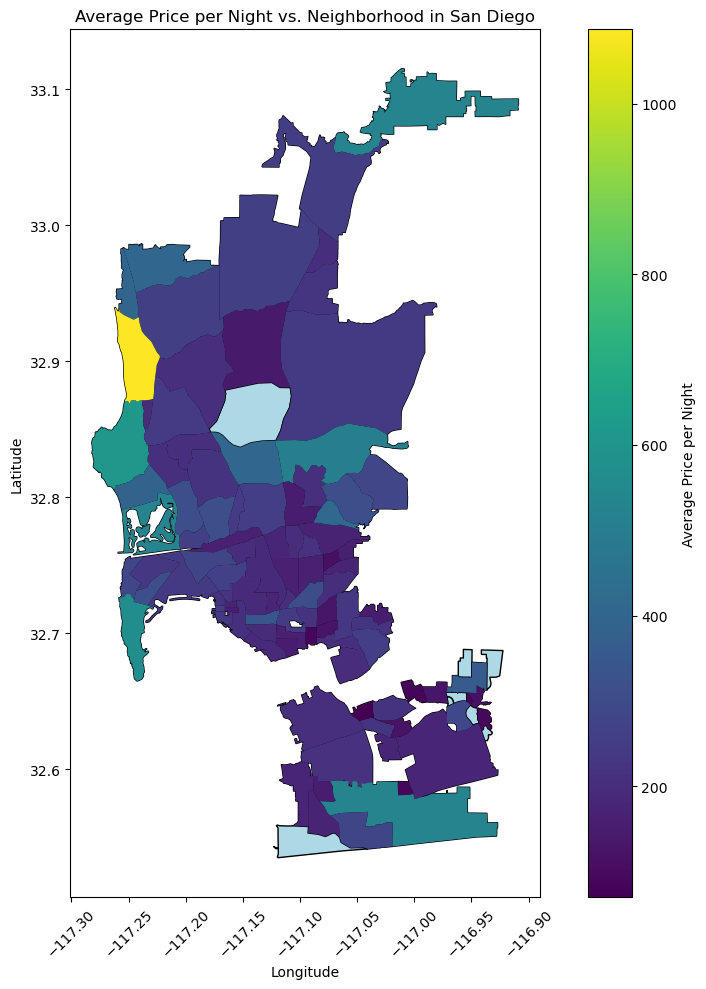

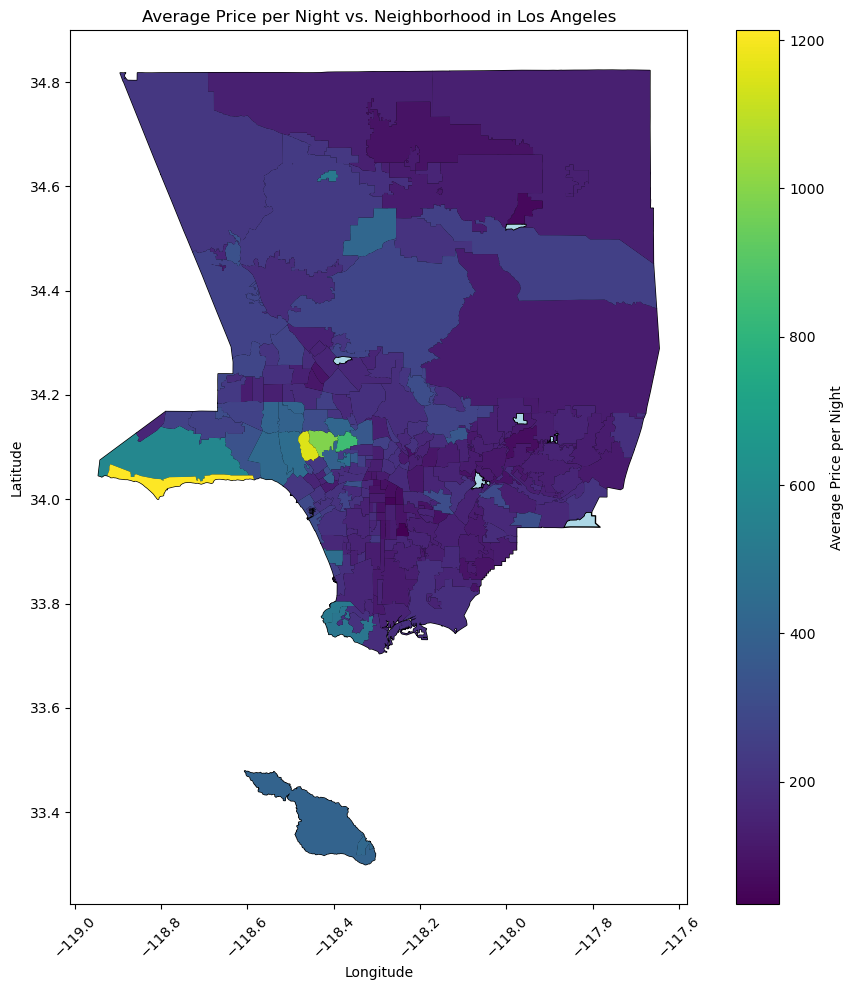

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

san_diego_data = pd.read_csv('san_diego_listing_cleaned.csv')
san_diego_shapefile = "neighborhoods/sandiego.geojson"

los_angeles_data = pd.read_csv('los_angeles_listing_cleaned.csv')
los_angeles_shapefile = "neighborhoods/losangeles.geojson"

def plot(shapefile_path, data, title):
    """
    Plot the given airbnb on the map using the shapefile as the map background.
    """
    gdf = gpd.read_file(shapefile_path)

    average_price_per_neighborhood = data.groupby('neighbourhood_cleansed')['price'].mean().sort_values()
    # print(average_price_per_neighborhood)
    # Plot the neighborhoods
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='lightblue', edgecolor='black')

    # Plot the average price per neighborhood
    gdf['average_price'] = gdf['neighbourhood'].map(average_price_per_neighborhood)
    gdf.plot(column='average_price', ax=ax, legend=True, legend_kwds={'label': "Average Price per Night"})

    #rotate the x-axis labels
    plt.xticks(rotation=45)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Average Price per Night vs. Neighborhood in {}'.format(title))
    plt.tight_layout()

#Plot san diego first then los angeles
plot(san_diego_shapefile, san_diego_data, "San Diego")
plot(los_angeles_shapefile, los_angeles_data, "Los Angeles")